In [1]:
import tensorflow as tf
from deeponet import DeepONet, CosineAnnealingSchedule
from utils import *
import matplotlib.pyplot as plt
from flow import Flow
import numpy as np

2024-11-16 13:58:53.761644: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 13:58:53.813324: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [ ]:
model = DeepONet(
    n_branch = 64, 
    n_trunk = 2, 
    width = 100, 
    depth = 3, 
    output_dim = 100,
    activation = "relu",
    grid_size = (128, 128)
)

lr_schedule = CosineAnnealingSchedule(
    initial_learning_rate=0.001, 
    decay_steps=100,  
    alpha=0.0 
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
dataloader = DarcyDatasetLoader("DarcyDataset")
train_dataset, test_dataset = dataloader.get_split(test_size = 0.2, batch_size = -1, frac = 0.8)

In [ ]:
def downsample(a, u):
    a = tf.expand_dims(a, axis=-1) 
    a = tf.expand_dims(a, axis=0) 
    pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

    a_downsampled = pooling_layer(a)
    a_downsampled = tf.squeeze(a_downsampled)

    return a_downsampled, u

In [ ]:
train_dataset = train_dataset.map(lambda a, u : downsample(a, u/1e-2))
test_dataset  = test_dataset.map(lambda a, u : downsample(a, u/1e-2))

In [ ]:
X_train = tf.convert_to_tensor(
    list(train_dataset.map(lambda a, u: a).as_numpy_iterator())
)
y_train = tf.convert_to_tensor(
    list(train_dataset.map(lambda a, u: tf.reshape(u, [-1])).as_numpy_iterator())
)

In [ ]:
flow = Flow(
    prior = None,
    likelihood_std=np.sqrt(2), 
    k=0.0,
    n_epochs_recorded= 1
)

flow.compile(
    optimizer=optimizer,
    n_models=1, 
    lr_schedule=lr_schedule
)

In [ ]:
flow.flow(
    model = model, 
    x=X_train, 
    y=y_train, 
    epochs = 1_000, 
    batch_size = 128,
)

Training Epochs:   0%|          | 0/1000 [00:00<?, ?epoch/s]

2024-11-16 13:44:00.639532: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


KeyboardInterrupt: 

In [ ]:
est_IP = flow.get_estimator(name='importance_sampling')
est_DP = flow.get_estimator(name='deep_ensemble')

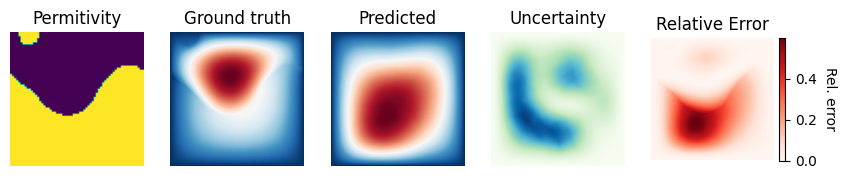

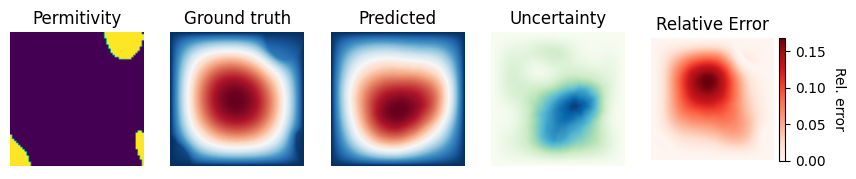

In [ ]:
import matplotlib.pyplot as plt

for a, u in test_dataset.take(2):
    fig, ax = plt.subplots(1, 5, figsize=(10, 5))
    
    u_pred, std = est_IP(a[None, ...])
    u_pred, std = u_pred, std
    u_pred = tf.reshape(u_pred, (128,128))
    std = tf.reshape(std, (128,128))
    
    ax[0].imshow(tf.reshape(a, (64, 64)), cmap = "viridis")
    ax[0].set_axis_off()
    ax[0].set_title("Permitivity")
    ax[1].imshow(u, cmap = "RdBu_r")
    ax[1].set_axis_off()
    ax[1].set_title("Ground truth")
    ax[2].imshow(u_pred, cmap = "RdBu_r")
    ax[2].set_axis_off()
    ax[2].set_title("Predicted")
    ax[3].imshow(std, cmap = "GnBu")
    ax[3].set_axis_off()
    ax[3].set_title("Uncertainty")

    u = tf.cast(u, dtype=tf.float32)  # Cast u to float32
    u_pred = tf.cast(u_pred, dtype=tf.float32) 
    im3 = ax[4].imshow(np.abs(u_pred - u)**2 / np.max(u**2), cmap = "Reds")
    ax[4].set_axis_off()
    ax[4].set_title("Relative Error")
    cbar = fig.colorbar(im3, ax=ax[4], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label('Rel. error', rotation=270, labelpad=15)
    plt.show()

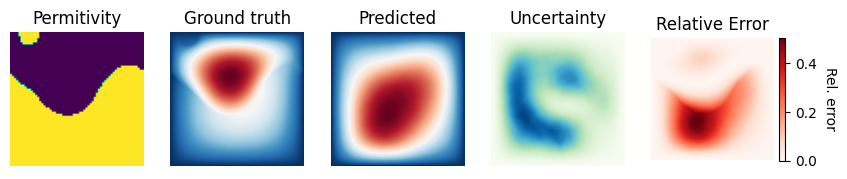

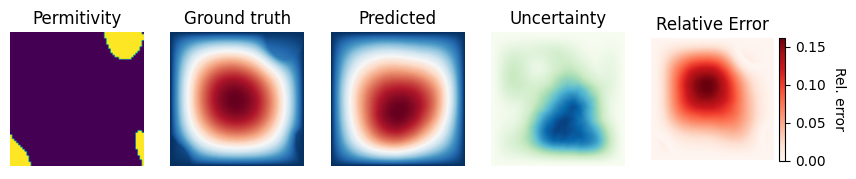

In [ ]:
for a, u in test_dataset.take(2):
    fig, ax = plt.subplots(1, 5, figsize=(10, 5))
    
    u_pred, std = est_DP(a[None, ...])
    u_pred, std = u_pred, std
    u_pred = tf.reshape(u_pred, (128,128))
    std = tf.reshape(std, (128,128))
    
    ax[0].imshow(tf.reshape(a, (64, 64)), cmap = "viridis")
    ax[0].set_axis_off()
    ax[0].set_title("Permitivity")
    ax[1].imshow(u, cmap = "RdBu_r")
    ax[1].set_axis_off()
    ax[1].set_title("Ground truth")
    ax[2].imshow(u_pred, cmap = "RdBu_r")
    ax[2].set_axis_off()
    ax[2].set_title("Predicted")
    ax[3].imshow(std, cmap = "GnBu")
    ax[3].set_axis_off()
    ax[3].set_title("Uncertainty")

    u = tf.cast(u, dtype=tf.float32)  # Cast u to float32
    u_pred = tf.cast(u_pred, dtype=tf.float32) 
    im3 = ax[4].imshow(np.abs(u_pred - u)**2 / np.max(u**2), cmap = "Reds")
    ax[4].set_axis_off()
    ax[4].set_title("Relative Error")
    cbar = fig.colorbar(im3, ax=ax[4], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label('Rel. error', rotation=270, labelpad=15)
    plt.show()